In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import seaborn as sns

# !pip install -U scikit-learn
from sklearn.preprocessing import minmax_scale

In [3]:
def plot_save(imarray,fname):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(imarray.shape[1],imarray.shape[0])
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    # ax.imshow(im_np, aspect='normal')
    ax.imshow(imarray, cmap="Greys_r")
    fig.savefig(fname,dpi=1)

In [4]:
def draw_contour(image_base,mask):
    labels = np.unique(mask)[1:]

    #create RGB pallet
    pallete = sns.color_palette(None,len(labels))
    pallete = list(map(lambda x: (int(x[0]*255),int(x[1]*255),int(x[2]*255)),pallete))


    for i,label in enumerate(labels):
        image_bin = ((mask==label)*255).astype(np.uint8)
        contours, _ = cv2.findContours(image_bin, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(image_base,contours, -1, pallete[i], 2)
    return image_base

In [5]:
def add_mask_contour(mask,image_base=None):
    if image_base is None:
        image_base = np.zeros(mask.shape[:2]+(3,))

    
    #Add RGB Channels
    if image_base.shape[-1]!=3:
        image_base = np.expand_dims(image_base,axis=-1)
        image_base = np.concatenate([image_base,image_base,image_base],axis=-1)

    #Simple Convert 8bits
    if not image_base.dtype is np.uint8:
        image_base = minmax_scale(image_base.reshape(-1,1),(0,255)).reshape(image_base.shape).astype(np.uint8)
    
    if len(image_base.shape) ==4:
        for i in range(image_base.shape[0]):
            image_base[i] = draw_contour(image_base[i],mask[i])
    else:
        image_base = draw_contour(image_base,mask)    

    return image_base

In [6]:
def savefig_3d_to_2d(image,filename):
    
    c = 10
    r = image.shape[0]//c
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(image[cnt])#, cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

    fig.set_size_inches(c*image.shape[1],r*image.shape[2])

    fig.savefig(filename,dpi=1)

In [7]:
# load dataset
def load_images(path_src, path_mask, path_out_net):
    src_npz = np.load(path_src, allow_pickle=True)
    tar_npz = np.load(path_mask, allow_pickle=True)
    out_net = np.load(path_out_net, allow_pickle=True)
    
    src = np.concatenate(src_npz['arr_0'])
    tar = np.concatenate(tar_npz['arr_0'])
    out = np.concatenate(out_net['arr_0'])
    
    return src, tar, out

In [8]:
# dataset path base 1
test_src_b1 = '/home/anatielsantos/mestrado/datasets/dissertacao/final_tests_dis/samples/test_images_b1.npz'
test_mask_b1 = '/home/anatielsantos/mestrado/datasets/dissertacao/final_tests_dis/samples/test_masks_b1.npz'
pred_unet_b1 = '/home/anatielsantos/mestrado/datasets/dissertacao/final_tests_dis/samples/unet_pred_b1.npz'
pred_gan_b1 = '/home/anatielsantos/mestrado/datasets/dissertacao/final_tests_dis/samples/gan_pred_b1.npz'

# dataset path base 2
test_src_b2 = '/home/anatielsantos/mestrado/datasets/dissertacao/final_tests_dis/samples/test_images_b2.npz'
test_mask_b2 = '/home/anatielsantos/mestrado/datasets/dissertacao/final_tests_dis/samples/test_masks_b2.npz'
pred_unet_b2 = '/home/anatielsantos/mestrado/datasets/dissertacao/final_tests_dis/samples/unet_pred_b2.npz'
pred_gan_b2 = '/home/anatielsantos/mestrado/datasets/dissertacao/final_tests_dis/samples/gan_pred_b2.npz'

In [24]:
# load dataset
[src_images_test, tar_images_test, tar_out_mask] = load_images(test_src_b2, test_mask_b2, pred_gan_b2)
tar_out_mask = tar_out_mask * 2
nova_mask = np.maximum(tar_images_test, tar_out_mask)

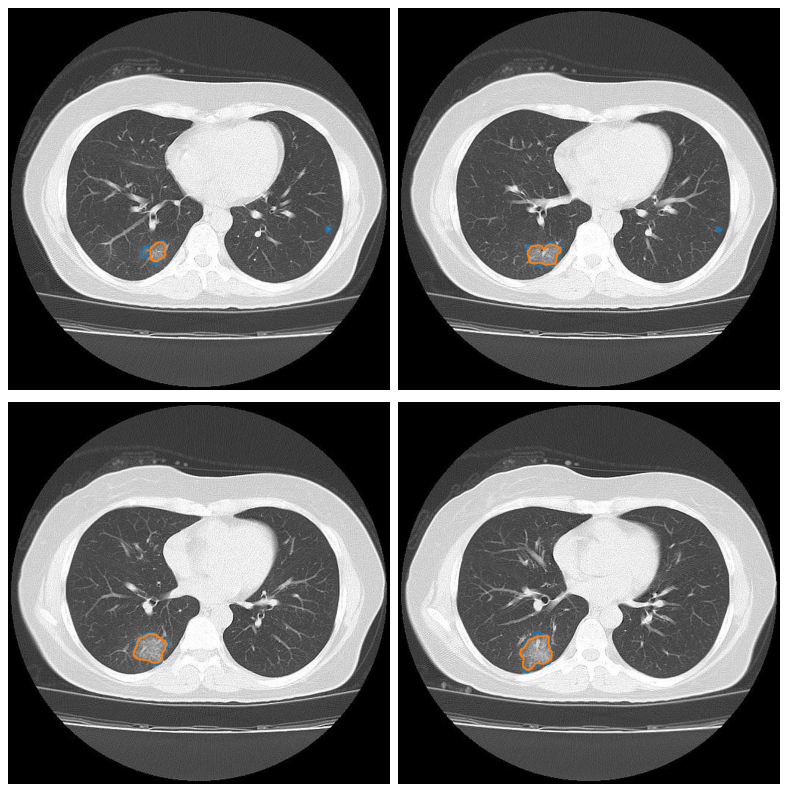

In [32]:
width=10
height=10
rows = 2
cols = 2
axes=[]
fig=plt.figure(figsize=(width, height), dpi=80)

for a in range(rows*cols):
    b = add_mask_contour(nova_mask[17+a], src_images_test[17+a])
    axes.append( fig.add_subplot(rows, cols, a+1) )
    plt.axis('off')
    plt.imshow(b)
fig.tight_layout()    
plt.show()


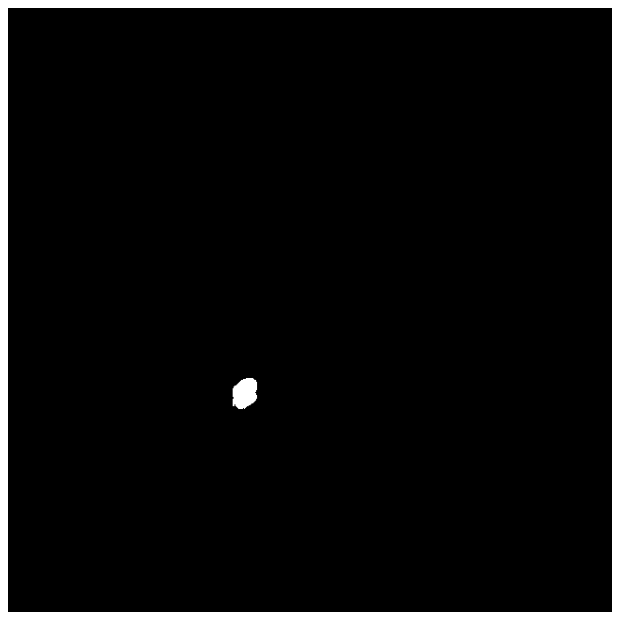

In [27]:
plt.figure(figsize=(10, 10), dpi=80)
plt.axis('Off')
plt.imshow(tar_out_mask[17], cmap='gray')

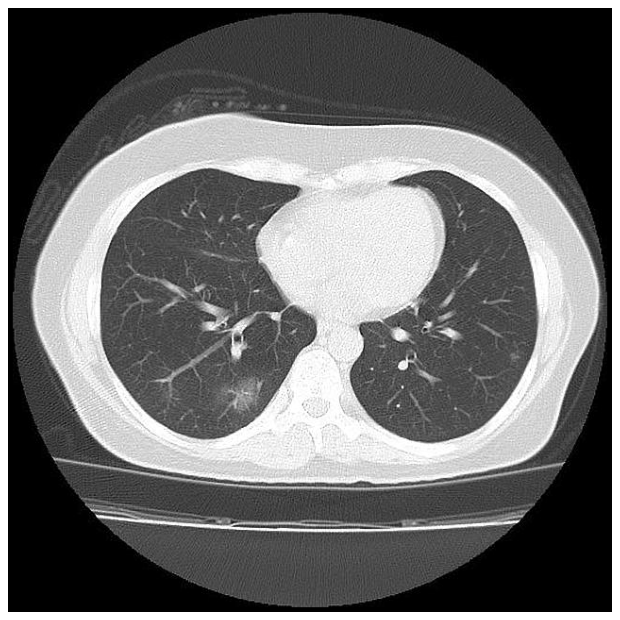

In [28]:
plt.figure(figsize=(10, 10), dpi=80)
plt.axis('Off')
plt.imshow(src_images_test[17], cmap='gray')